In [2]:
import pandas as pd
import numpy as np

gdata_df = pd.read_csv('GData.csv')
activity_df = pd.read_excel('Activity_01012022_31032022.xlsx', sheet_name='Sheet1')


#joiing delivery schedule lines with gdata on EBELN and EBELP
# in gdata 76412, in deliv_Df 12394 common 12159 on PO number and item number
delivery_schedule_lines_df = pd.read_excel('Delivery Schedule Lines of a Purchasing Document.xlsx')
df= delivery_schedule_lines_df.groupby(['Purchasing Document Number', 'Item Number of Purchasing Document'])['Delivery Date of Vendor Confirmation'].max().reset_index()

merged_df = gdata_df.merge(df, left_on=['EBELN', 'EBELP'], right_on=['Purchasing Document Number', 'Item Number of Purchasing Document'], how='left')
#joining scheduling_agreement_schedule_lines_df with merged_df
scheduling_agreement_schedule_lines_df = pd.read_excel('Scheduling Agreement Schedule Lines.xlsx')
df=scheduling_agreement_schedule_lines_df.groupby(['Purchasing Document Number', 'Item Number of Purchasing Document'])['Item Delivery Date'].max()
df=pd.DataFrame(df).reset_index()

merged_df = merged_df.merge(df[['Purchasing Document Number', 'Item Number of Purchasing Document', 'Item Delivery Date']], 
                            left_on=['EBELN', 'EBELP'], 
                            right_on=['Purchasing Document Number', 'Item Number of Purchasing Document'], 
                            how='left')
# Create a new column 'expected_delivery_date' with default value as 'Item Delivery Date'
merged_df['expected_delivery_date'] = merged_df['Item Delivery Date']

# Replace the values with 'Delivery Date of Vendor Confirmation' where it is not null
merged_df.loc[merged_df['Delivery Date of Vendor Confirmation'].notnull(), 'expected_delivery_date'] = merged_df['Delivery Date of Vendor Confirmation']


#Adding expected_GR_days and delay_flag column to the merged_df
merged_df['expected_GR_days'] = (pd.to_datetime(merged_df['expected_delivery_date']) - pd.to_datetime(merged_df['createtime'])).dt.days
merged_df['GR_delay'] = merged_df['GDdays'] - merged_df['expected_GR_days']
merged_df['GR_delay_flag'] = merged_df['GR_delay'].apply(lambda x: 1 if x > 0 else 0)

#column_order = ['X_CASE_KEY', 'EBELN', 'EBELP', 'createtime', 'firstreceivetime', 'Delivery Date of Vendor Confirmation', 'GDdays', 'expected_GR_days', 'GR_delay', 'changeconfirmeddeliverydate', 'changecontract', 'changecurrency', 'changedeliveryindicator', 'changefinalinvoiceindicator', 'changeoutwarddeliveryindicator', 'changeprice', 'changequantity', 'changerequesteddeliverydate', 'changestoragelocation', 'numdelivery', 'BUKRS', 'MATKL', 'MATNR', 'NETPR', 'PSTYP', 'WERKS', 'ERNAM', 'GR_delay_flag']

#merged_df = merged_df.reindex(columns=column_order)

# Transform GDdays and GR_delay columns
merged_df['GDdays_log'] = np.log(merged_df['GDdays'] + 1)
merged_df['GR_delay_log'] = np.where(merged_df['GR_delay'] > 0, np.log(merged_df['GR_delay'] + 1), 0)
#join PR table to get PR to PO delay, and creation indicator
#gdata=76412 purchase_requisition_df=45179 commmon 37339 on POnumber and item number
#'Creation Indicator (Purchase Requisition/Schedule Lines)' and prtoPOdelay use in regression model
purchase_requisition_df = pd.read_excel('Purchase Requisition.xlsx')
order_delay = purchase_requisition_df.groupby(['Purchase Order Number', 'Item Number of Purchasing Document','Creation Indicator (Purchase Requisition/Schedule Lines)']).apply(lambda x: (x['Purchase Order Date'] - x['Requisition (Request) Date']).max()).reset_index()
order_delay.columns = ['Purchase Order Number', 'Item Number of Purchasing Document','Creation Indicator (Purchase Requisition/Schedule Lines)', 'PR_to_PO_delay']
merged_df = merged_df.merge(order_delay, left_on=['EBELN', 'EBELP'], right_on=['Purchase Order Number', 'Item Number of Purchasing Document'], how='left')
#join with purchasing document header to get Vendor and Currency information
purchasing_document_header_df = pd.read_excel('Purchasing Document Header.xlsx')
merged_df = merged_df.merge(purchasing_document_header_df[['Purchasing Document Number', 'Purchasing Group', 'Purchasing Organization', 'Vendor Account Number', 'Currency Key', 'Exchange Rate']], 
                            left_on='EBELN', right_on='Purchasing Document Number', how='left')
merged_df=merged_df[['X_CASE_KEY', 'EBELN', 'EBELP', 'createtime', 'firstreceivetime',
    'changeconfirmeddeliverydate', 'changecontract', 'changecurrency',
    'changedeliveryindicator', 'changefinalinvoiceindicator',
    'changeoutwarddeliveryindicator', 'changeprice', 'changequantity',
    'changerequesteddeliverydate', 'changestoragelocation', 'numdelivery',
    'GDdays', 'BUKRS', 'MATKL', 'MATNR', 'NETPR', 'PSTYP', 'WERKS', 'ERNAM',       
    'Delivery Date of Vendor Confirmation', 'Item Delivery Date',
    'expected_delivery_date', 'expected_GR_days', 'GR_delay',
    'GR_delay_flag', 'GDdays_log', 'GR_delay_log',
    'Creation Indicator (Purchase Requisition/Schedule Lines)',
    'PR_to_PO_delay', 'Purchasing Document Number', 'Purchasing Group',
    'Purchasing Organization', 'Vendor Account Number', 'Currency Key',
    'Exchange Rate']]
#total invoice value, and quantity
#purchasing_document_item_df 86402 gdata and merged 76412 
purchasing_document_item_df = pd.read_excel('Purchasing Document Item.xlsx')
selected_columns = ['Purchasing Document Number', 'Item Number of Purchasing Document', 'Storage Location', 'Price Unit', 'Purchase Order Unit of Measure', 'Net Price in Purchasing Document (in Document Currency)', 'Net Order Value in PO Currency']
purchasing_document_item_df['Quantity'] = purchasing_document_item_df['Net Order Value in PO Currency'] / purchasing_document_item_df['Net Price in Purchasing Document (in Document Currency)']
selected_df = purchasing_document_item_df[selected_columns + ['Quantity']]

# Perform left join without specifying suffixes
merged_df = merged_df.merge(selected_df, how='left', left_on=['EBELN', 'EBELP'], right_on=['Purchasing Document Number', 'Item Number of Purchasing Document'])
merged_df=merged_df[['EBELN', 'EBELP', 'createtime', 'firstreceivetime','expected_delivery_date','expected_GR_days', 'GR_delay',
       'GR_delay_flag', 'GDdays_log', 'GR_delay_log',
       'changeconfirmeddeliverydate', 'changecontract', 'changecurrency',
       'changedeliveryindicator', 'changefinalinvoiceindicator',
       'changeoutwarddeliveryindicator', 'changeprice', 'changequantity',
       'changerequesteddeliverydate', 'changestoragelocation', 'numdelivery',
       'GDdays', 'BUKRS', 'MATKL', 'MATNR', 'NETPR', 'PSTYP', 'WERKS', 'ERNAM',
       'Delivery Date of Vendor Confirmation', 'Item Delivery Date', 
       'Creation Indicator (Purchase Requisition/Schedule Lines)',
       'PR_to_PO_delay', 'Purchasing Group',
       'Purchasing Organization', 'Vendor Account Number', 'Currency Key',
       'Exchange Rate', 'Storage Location', 'Price Unit',
       'Purchase Order Unit of Measure',
       'Net Price in Purchasing Document (in Document Currency)',
       'Net Order Value in PO Currency', 'Quantity']]

merged_df['NETPR_normalized'] = merged_df['NETPR'] * merged_df['Exchange Rate']
n = 103

# Define the bin edges
bins = [3*i for i in range(n)]
labels = range(1, n)
# Bin the values in the 'expected_GR_days' column
merged_df['expected_GR_days_bin'] = pd.cut(merged_df['expected_GR_days'], bins=bins, labels=labels, right=False)
merged_df['GR_delay_bin'] = pd.cut(merged_df['GR_delay'], bins=bins, labels=labels, right=False)
merged_df['GDdays_bin'] = pd.cut(merged_df['GDdays'], bins=bins, labels=labels, right=False)
merged_df['GR_delay_flag'] = merged_df['GR_delay_bin'].apply(lambda x: 1 if x > 1 else 0)

In [25]:
data=merged_df.copy()

# Create a new column for normalized values
data['NETPR_normalized'] = data['NETPR'] * data['Exchange Rate']

# Apply log transformation to the normalized values
data['NETPR_normalized_log'] = np.log(data['NETPR_normalized'])

# Apply scaling to the normalized values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['NETPR_normalized_scaled'] = scaler.fit_transform(data['NETPR_normalized'].values.reshape(-1, 1))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd

# Assume 'data' is your preprocessed DataFrame

# Encode categorical variables
label_encoders = {}
for column in ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Regression

In [26]:
final_data_regression = data[['expected_GR_days', 'Vendor Account Number', 'MATKL', 'NETPR_normalized_scaled', 
          'Currency Key', 'Quantity', 'WERKS'] + 
          ['changerequesteddeliverydate', 'changeprice', 'changequantity', 
          'changecurrency', 'changedeliveryindicator', 'changefinalinvoiceindicator', 
          'changestoragelocation', 'changeconfirmeddeliverydate', 
          'changecontract', 'changeoutwarddeliveryindicator','GR_delay_log']]
final_data_regression.to_csv('final_data_regression.csv', index=False)


MLP

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your data
# final_data = pd.read_csv('path_to_your_data.csv')
# Assume final_data is already loaded as mentioned

# Split data into features and target
X = final_data_regression.drop('GR_delay_log', axis=1)
y = final_data_regression['GR_delay_log']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train, y_train)

# Predict using the test set
y_pred = mlp.predict(X_test)

# Calculate and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

print("the model is not able to capture the underlying patterns in the data and is not able to make accurate predictions.")


ValueError: Input X contains NaN.
MLPRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

XGboost

Mean Squared Error: 0.7586421438027575
R² Score: 0.3744392099897159


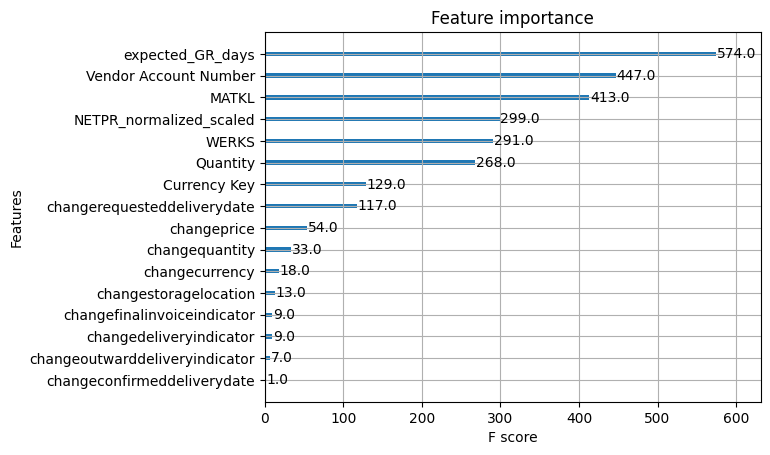

In [28]:
# Define features X and target y
X = final_data_regression.drop('GR_delay_log', axis=1)
y = final_data_regression['GR_delay_log']

from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import xgboost as xgb

# Define the XGBoost regressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score

# Predicting the Test set results
y_pred = xgb_model.predict(X_test)

# Calculate MSE and R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(xgb_model)
plt.title('Feature importance')
plt.show()

Random Forest

Random Forest Mean Squared Error: 0.9351740895014312
Random Forest R² Score: 0.2288745793988448


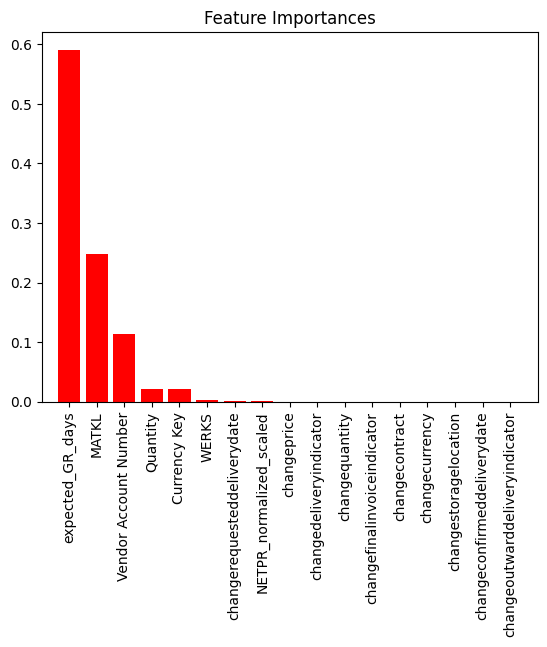

In [29]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5, n_jobs=-1)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predicting the Test set results
y_rf_pred = rf_model.predict(X_test)

# Calculate MSE and R²
mse_rf = mean_squared_error(y_test, y_rf_pred)
r2_rf = r2_score(y_test, y_rf_pred)

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R² Score: {r2_rf}')

# Feature importance visualization
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [30]:
data=merged_df.copy()

# Create a new column for normalized values
data['NETPR_normalized'] = data['NETPR'] * data['Exchange Rate']

# Apply log transformation to the normalized values
data['NETPR_normalized_log'] = np.log(data['NETPR_normalized'])

# Apply scaling to the normalized values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['NETPR_normalized_scaled'] = scaler.fit_transform(data['NETPR_normalized'].values.reshape(-1, 1))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd

# Assume 'data' is your preprocessed DataFrame

# Encode categorical variables
label_encoders = {}
for column in ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

# Prepare the features and target variable
X = data[['expected_GR_days', 'Vendor Account Number', 'MATKL', 'NETPR_normalized_scaled', 
          'Currency Key', 'Quantity', 'WERKS'] + 
          ['changerequesteddeliverydate', 'changeprice', 'changequantity', 
          'changecurrency', 'changedeliveryindicator', 'changefinalinvoiceindicator', 
          'changestoragelocation', 'changeconfirmeddeliverydate', 
          'changecontract', 'changeoutwarddeliveryindicator']]
y = data['GR_delay_log']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Calculate RMSE
rmse = (mean_squared_error(y_test, y_pred))

print(f'Root Mean Squared Error: {rmse}')





/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Root Mean Squared Error: 0.540818350867315


Classification

In [31]:
final_data_classification = data[['expected_GR_days', 'Vendor Account Number', 'MATKL', 'NETPR_normalized_scaled', 
          'Currency Key', 'Quantity', 'WERKS'] + 
          ['changerequesteddeliverydate', 'changeprice', 'changequantity', 
          'changecurrency', 'changedeliveryindicator', 'changefinalinvoiceindicator', 
          'changestoragelocation', 'changeconfirmeddeliverydate', 
          'changecontract', 'changeoutwarddeliveryindicator','GR_delay_flag']]
final_data_classification.to_csv('final_data_classification.csv', index=False)
